# Tutorial 5.2: Detecting Circuit Structure and Nonrandom features within a Connectivity Matrix
## Neuroscience goal:
- acquire techniques that are useful in the analysis of connectivity data
## Computational goal:
- gain experience at manipulating, sorting, and shuffling rows or columns of matrices
- practice using while loops

### Overview 
- will produce a connectivity matrix with a structure that is not clear by inspection
- will write an algorithm to extract the 'hidden' structure and to analyze for motifs present significantly above chance

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Part A
### 1. Create a vector of len $N_{cells}$
- where $N_{cells} = 60$, such that each element is a random integer from 1 to 4
- use MATLAB functions ceil and rand, or randi

In [2]:
np.random.seed(0)
n_cells = 60

cells = np.random.randint(1, 5, n_cells)

### 2. Create a connection matrix, $\bold C$, of size $N_{cells} \times N_{cells}$
- each element, $C_{ij}$, representing the presence or not of a connection from neuron $i$ to $j$, is 1 or 0
- let $C_{ij}$ = 1 with probability of $p_0 = 0.1$ if neurons $i$ and $j$ belong to different groups, and with a probability of $p_1 = 0.5$ if they belong to the same group

In [13]:
p0 = 0.1
p1 = 0.5

c = np.where(cells[:, np.newaxis] == cells[np.newaxis, :],
             np.random.rand(n_cells, n_cells) < p1,
             np.random.rand(n_cells, n_cells) < p0)

np.fill_diagonal(c, 0)

### 3. plot the connection matrix in 2D

Text(0, 0.5, 'j')

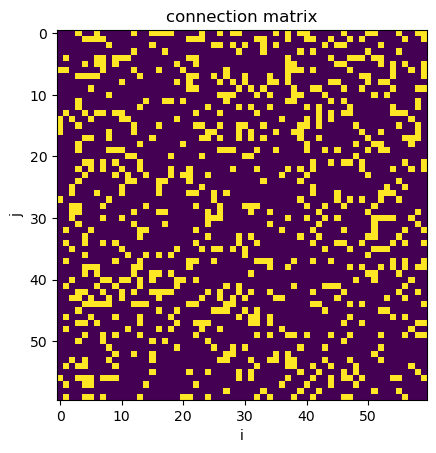

In [18]:
plt.imshow(c)
plt.title('connection matrix')
plt.xlabel('i')
plt.ylabel('j')

## Part B
- goal is to rearrange the neurons into their respective groups so tha tthe structure of the connection matrix become visible
### 4. create two correlation matrices
- one set of correlations between all the outgoing connections of all cells
- other set between all the incoming correlations of all cells
- if two cells belong ot the same group, their connections will be more strongly correlated than between two cells of different groups
### a. calculate correlation matrix for outgoing connections
- evaluate correlations between all pairs of row vectors
- correlation matrix will be produced to be size of ($N_{cells} \times N_{cells}$) with a diagonal of 1
### b. repeat (a) with all pairs of column vectors
### c. sum the two correlation matrices to produce a matrix called total_corr and plot histogram of values

In [23]:
outgoing = np.corrcoef(c, rowvar=True)
incoming = np.corrcoef(c, rowvar=False)
total_corr = outgoing + incoming

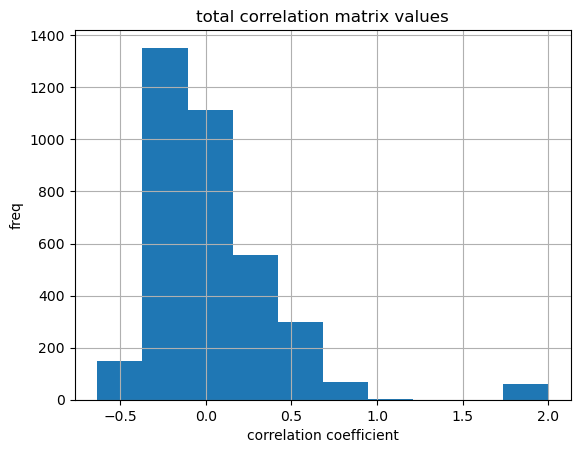

In [32]:
plt.hist(total_corr.flatten())
plt.title('total correlation matrix values')
plt.xlabel('correlation coefficient')
plt.ylabel('freq')
plt.grid(True)

### 5. set a threshold for correlation between two cells
- if correlation is above threshold, ascribe same group identity
- number of resulting groups will depend on threshold
    - if set too low, only one group
    - if set too high, too many groups
    - choose threshold such that 10 percent of correlations are above threshold

In [36]:
thresh = np.percentile(total_corr.flatten(), 90)

### 6. assign cells to groups
- create zeros vector to contain (*discovered*) group identities of each cell
- set new group counter variable to zero, run for loop running from 1 to $N_{cells}$

### 7. check assigned identity and increment 
- if group id is 0, increase group count by one to commence extraction of new group
- if currently assigned group ID is above zero, cell has been found within a completed cell group, so increase i by 1 and test whether the next cell requires a new group 

### 8. initialize two vectors
- one containing cells in the group whose high-correlation partners remain to be found (a 'remaining' list)
- one used to contain cells in the group whose high-correlation partners have been found (a 'used' list)
- first vector is initialized with single element (i)
- second is initialized as empty vector

### 9. create a while loop to run until `remaining` is empty
- once the list of remaining cells is empty, code should go to next step of for loop and increment i by 1
    - within while loop, extract neuron that is first element of the list of remaining cells
    - find all cells with correlation greater than threshold with this neuron
    - give current group identity to all of those cells 
    - add current neuron to `used` list and add group of cells just found to `remaining`
    - remove all double counts on `remaining` list, so each cell appears only once
    - remove from `remaining` any that are on `used`
        - to avoid endless loop

### 10. end the for loop so code returns to next cell

In [39]:
group_ids = np.zeros(n_cells)

id = 0

for i in range(n_cells):
    if group_ids[i] == 0: # If cell has not been assigned
        remaining = [i]
        used = []
        id += 1
        group_ids[i] = id

        while len(remaining) > 0:
            # Extract neuron
            cell = remaining[0]
            # Find high-correlation cells
            partners = np.where(total_corr[cell, :] > thresh)[0]
            # Give current group ID to partner neurons
            for p in partners:
                if group_ids[p] == 0:
                    group_ids[p] = id
                    # Add partners to remaining
                    remaining.append(p)
            # Add neuron to `used`
            used.append(cell)
            # Remove duplicates in remaining
            remaining = list(set(remaining))
            # Remove from `remaining` any cells that are in `used`
            remaining = [cell for cell in remaining if cell not in used]

### 11. use `sort` command to sort the list of group identities
- be sure to store the indices such that alongside the sorted list of group IDs is the list of cells to which the group IDs belong
- produce and plot an alternative connection matrix where entries are reordered according to the sorted list of group IDs

Text(0, 0.5, 'sorter j')

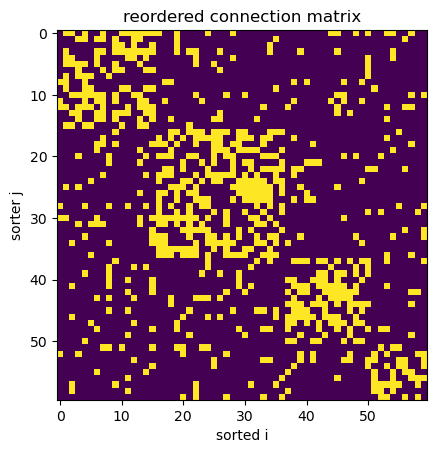

In [43]:
sorted_indices = np.argsort(group_ids)
sorted_ids = group_ids[sorted_indices]

sorted_matrix = c[sorted_indices, :][:, sorted_indices]

plt.imshow(sorted_matrix)
plt.title('reordered connection matrix')
plt.xlabel('sorted i')
plt.ylabel('sorter j')

# Challenge: Part C
- our goal is to extract motifs and compare their abundance with expectation by chance

### 12. find average connection probability, $\bar p$, between pairs of cells in original connection matrix

In [45]:
p_bar = np.mean(c)
p_bar

0.2063888888888889

### 13. find number of cell pairs with bidirectional connections and compare number with $\bar p$

In [68]:
bidirectional = (c * c.T)
# Remove diagonals
#np.fill_diagonal(bidirectional, 0)
num_bidirectional = np.sum(bidirectional) // 2

# Expected number of bidirectionals
expected_bidirectional = p_bar ** 2 * (n_cells * (n_cells - 1) // 2)

num_bidirectional, expected_bidirectional

(141, 75.39558101851853)

### 14. calculate probability of a cell pair having two connections, a single connection, or no connection
- total number of connections must be $N_{cells}\bar p = N_{pairs}p_1 + 2N_{pairs}p_2, where N_{pairs} = N_{cells}(N_{cells} - 1) / 2$ is the number of cell-pairs

In [69]:
total_pairs = n_cells * (n_cells - 1) # not including self-connections

# one connections pairs
uni_pairs = np.sum(c)

# two connection pairs
bi_pairs = num_bidirectional

# 0 connectino pairs
no_pairs = total_pairs - uni_pairs - 2*bi_pairs

# probs
p0 = no_pairs / total_pairs
p1 = uni_pairs / total_pairs
p2 = bi_pairs / total_pairs

p0, p1, p2

(0.71045197740113, 0.20988700564971752, 0.03983050847457627)

### 15. enumerate the number of each type of motif found in the connectivity matrix
- example: initialize a zero vector of length 16
    - using three nested loops from 1 to n_cells for variables i, j (with j>1), and k (with k>j), test each triplet of connections
    - add 1 to count of corresponding motif number

In [77]:
motifs = np.zeros(16)

for i in range(n_cells):
    for j in range(i + 1, n_cells):
        for k in range(j + 1, n_cells):
            # extract connections for current triplet
            connections = [c[i, j], c[j, k], c[k, i], c[j, i]]
            connections = [int(conn) for conn in connections]
            
            # get motif number for current set of connections
            motif_number = int(''.join(map(str, connections)), 2)

            # add to motifs vector
            motifs[motif_number] +=1 


### 16. compare with chance
- plot ratio of counts enumerated in (15) with expected number of motifs, $E_i$

$E_i = M(i)N_{triplets}p_0^{n_0(i)}p_1^{n_1(i)}p_2^{n_2(i)}$

- where $n_0(i), n_1(i), n_2(i)$ are the number of unconnected, unidirectionally connected, and bidirectionally connected cells in the motif
- where $N_{triplets} = N_{cells}(N_{cells} - 1)(N_{cells} - 2) / 6$ is the number of distinct cell-triples
- where $M(i)$ is number of ways of producing the motif by shuffling connections between the cells

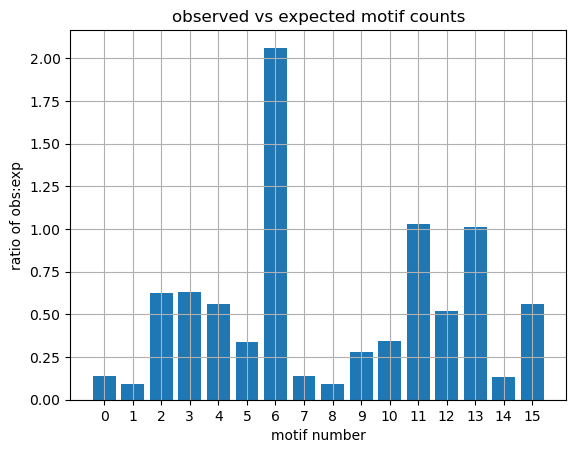

In [80]:
from scipy.special import comb
expected_motif_counts = np.zeros(16)

n_triplets = comb(n_cells, 3)
m_i = 6

for i in range(16):
    # convert motif to binary to find connection
    motif_bin = format(i, '04b')

    # count number of 0, 1, 2 connected cells in motif
    n0i = motif_bin.count('00')
    n1i = motif_bin.count('10') + motif_bin.count('01')
    n2i = motif_bin.count('11')

    # expected number of motifs for current motif
    expected_motif = m_i * n_triplets * (p0 ** n0i) * (p1 ** n1i) * (p2 ** n2i)
    expected_motif_counts[i] = expected_motif

# ratio observed to exptected
ratio = motifs / expected_motif_counts


plt.bar(range(16), ratio, label='observed/expected')
plt.xlabel('motif number')
plt.ylabel('ratio of obs:exp')
plt.title('observed vs expected motif counts')
plt.xticks(np.arange(16))
plt.grid(True)